#  Sales Summary Analysis using SQLite and Python

This notebook performs a basic sales analysis using a small SQLite database.

We’ll walk through:
- Creating a local database and inserting sample data
- Running SQL queries to summarize sales
- Visualizing revenue by product using matplotlib


## Step 1: Import Required Libraries

We begin by importing essential Python libraries for database connection, data manipulation, and visualization.


In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


## Step 2: Create or Connect to SQLite Database

We create a local SQLite database named `sales_data.db` and define a `sales` table with sample entries.


In [10]:
conn = sqlite3.connect("sales_data.db")
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS sales (
    id INTEGER PRIMARY KEY,
    product TEXT,
    quantity INTEGER,
    price REAL,
    date TEXT
)
''')

cursor.execute("SELECT COUNT(*) FROM sales")
if cursor.fetchone()[0] == 0:
    sample_data = [
        ('Laptop', 5, 1200.00, '2023-01-15'),
        ('Phone', 10, 800.00, '2023-01-16'),
        ('Tablet', 7, 500.00, '2023-01-17'),
        ('Laptop', 3, 1200.00, '2023-01-18'),
        ('Phone', 8, 800.00, '2023-01-19'),
        ('Tablet', 4, 500.00, '2023-01-20'),
        ('Laptop', 2, 1200.00, '2023-01-21'),
        ('Phone', 6, 800.00, '2023-01-22')
    ]
    cursor.executemany("INSERT INTO sales (product, quantity, price, date) VALUES (?, ?, ?, ?)", sample_data)
    conn.commit()


## Step 3: Sales Summary by Product

We run a SQL query to calculate total quantity sold and revenue for each product.


In [11]:
query1 = """
SELECT 
    product, 
    SUM(quantity) AS total_qty, 
    SUM(quantity * price) AS revenue 
FROM sales 
GROUP BY product
ORDER BY revenue DESC
"""
df_sales = pd.read_sql_query(query1, conn)
df_sales


,product,total_qty,revenue
0,Phone,24,19200.0
1,Laptop,10,12000.0
2,Tablet,11,5500.0


## Step 4: Overall Sales Summary

We calculate the total number of products, total items sold, and total revenue.


In [12]:
query2 = """
SELECT 
    COUNT(DISTINCT product) AS unique_products,
    SUM(quantity) AS total_items_sold,
    SUM(quantity * price) AS total_revenue
FROM sales
"""
df_summary = pd.read_sql_query(query2, conn)
df_summary


,unique_products,total_items_sold,total_revenue
0,3,45,36700.0


## Step 5: Visualize Revenue by Product

We use matplotlib to create a bar chart showing revenue per product.


<Figure size 1000x600 with 0 Axes>

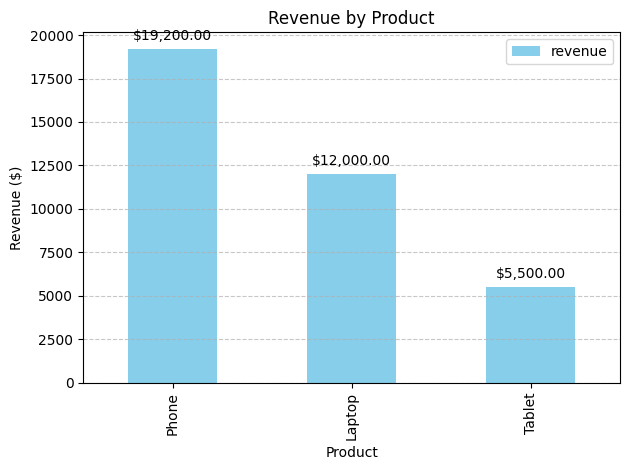

In [13]:
plt.figure(figsize=(10, 6))
ax = df_sales.plot(kind='bar', x='product', y='revenue', color='skyblue')
plt.title('Revenue by Product')
plt.xlabel('Product')
plt.ylabel('Revenue ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_sales['revenue']):
    ax.text(i, v + 500, f"${v:,.2f}", ha='center')

plt.tight_layout()
plt.show()


## Step 6: Daily Sales Trend

We analyze how revenue varies across different dates to identify peak sales days.


In [14]:
query3 = """
SELECT 
    date,
    SUM(quantity * price) AS daily_revenue
FROM sales
GROUP BY date
ORDER BY date
"""
df_daily = pd.read_sql_query(query3, conn)
df_daily


,date,daily_revenue
0,2023-01-15,6000.0
1,2023-01-16,8000.0
2,2023-01-17,3500.0
3,2023-01-18,3600.0
4,2023-01-19,6400.0
5,2023-01-20,2000.0
6,2023-01-21,2400.0
7,2023-01-22,4800.0


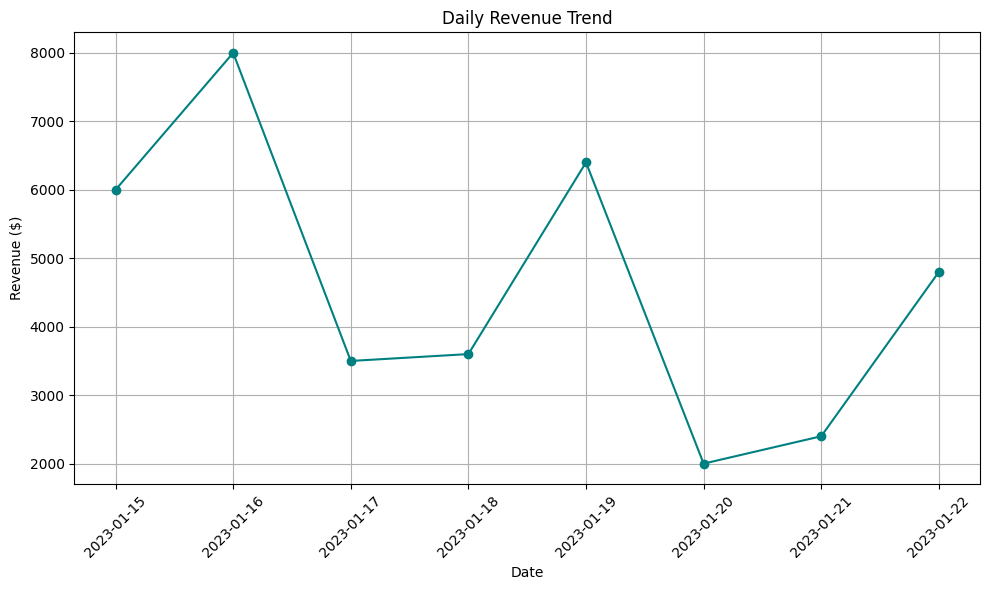

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df_daily['date'], df_daily['daily_revenue'], marker='o', linestyle='-', color='teal')
plt.title('Daily Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 7: Product-Wise Average Price

We calculate the average selling price per product to understand pricing strategy.


In [15]:
query4 = """
SELECT 
    product,
    ROUND(AVG(price), 2) AS avg_price
FROM sales
GROUP BY product
"""
df_avg_price = pd.read_sql_query(query4, conn)
df_avg_price


,product,avg_price
0,Laptop,1200.0
1,Phone,800.0
2,Tablet,500.0


## Step 8: Quantity Distribution by Product

We visualize how many units of each product were sold to compare popularity.


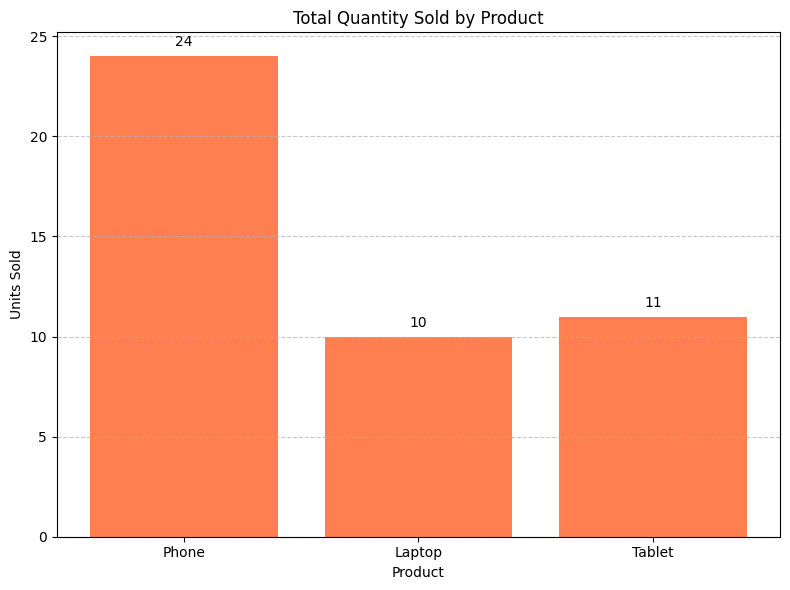

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(df_sales['product'], df_sales['total_qty'], color='coral')
plt.title('Total Quantity Sold by Product')
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_sales['total_qty']):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()


## Step 9: Revenue Share by Product

We use a pie chart to visualize each product's contribution to total revenue.


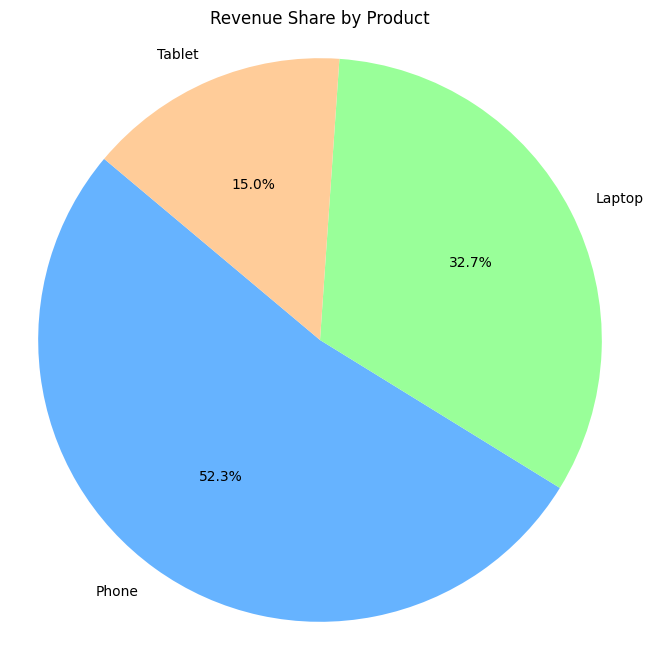

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(df_sales['revenue'], labels=df_sales['product'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Revenue Share by Product')
plt.axis('equal')  # Ensures pie is a circle
plt.show()


## Step 10: Cumulative Revenue Over Time

We track how revenue accumulates day by day to understand growth trends.


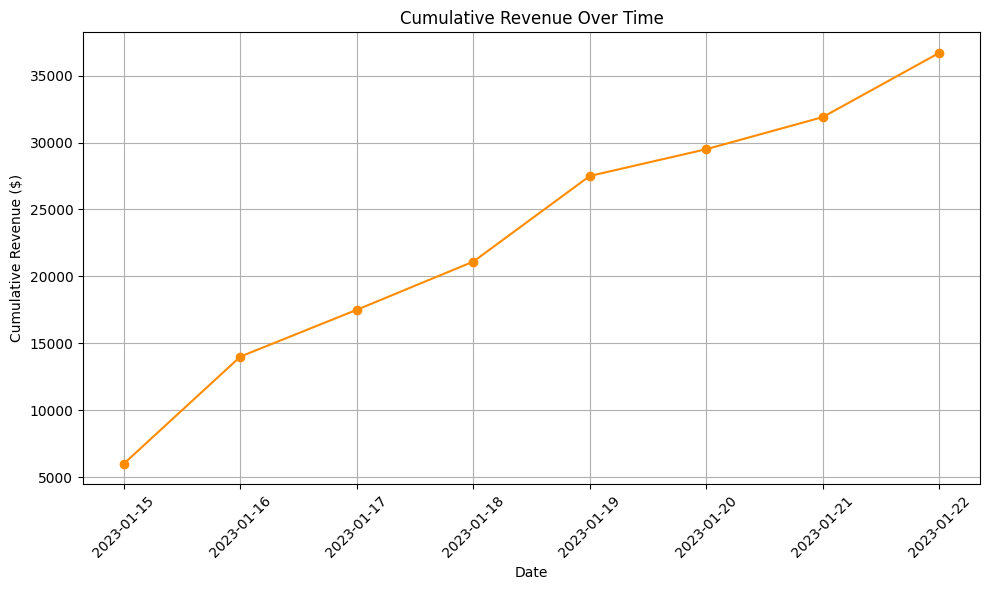

In [18]:
df_daily['cumulative_revenue'] = df_daily['daily_revenue'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_daily['date'], df_daily['cumulative_revenue'], marker='o', color='darkorange')
plt.title('Cumulative Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 11: Quantity Sold Over Time by Product

We use a stacked column chart to visualize how different products contributed to daily sales volume.


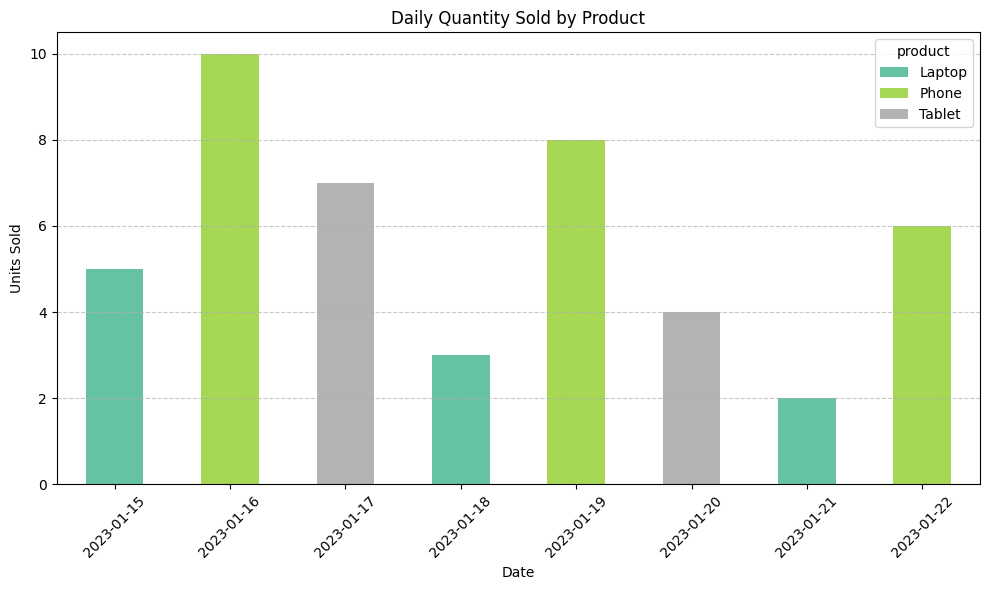

In [21]:
query5 = """
SELECT 
    date,
    product,
    SUM(quantity) AS qty
FROM sales
GROUP BY date, product
ORDER BY date
"""
df_stacked = pd.read_sql_query(query5, conn)

# Pivot for stacked bar chart
df_pivot = df_stacked.pivot(index='date', columns='product', values='qty').fillna(0)

df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Daily Quantity Sold by Product')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Step 6: Close Database Connection

We close the SQLite connection after completing the analysis.


In [22]:
conn.close()


## Step 13: Summary of Insights

Here’s a quick recap of what we discovered from the sales data:

- **Laptop** generated the highest revenue overall, despite fewer units sold compared to phones.
- **Phone** had the highest quantity sold, indicating strong demand.
- **Tablet** had moderate sales but a lower price point, contributing less to total revenue.
- **Daily revenue** peaked on certain dates, with cumulative growth visible over time.
- **Stacked bar chart** revealed how product mix varied across different sales days.
- **Average price analysis** confirmed consistent pricing across products.

This analysis demonstrates how SQL and Python can be combined to extract meaningful business insights from even a small dataset.

**Author**: Srusti  
**Date**: August 14, 2025  
**Tools Used**: SQLite, Pandas, Matplotlib  
**Objective**: Analyze product sales trends and revenue insights from a small dataset.
